In [1]:
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install seaborn

--- 1. EXTRACCIÓN DE DATOS ---
Datos cargados exitosamente en un DataFrame de Pandas.
DataFrame inicial (datos anidados):
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...

/tmp/ipython-input-1999050492.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Charges.Total'].fillna(0, inplace=True)
/tmp/ipython-input-1999050492.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

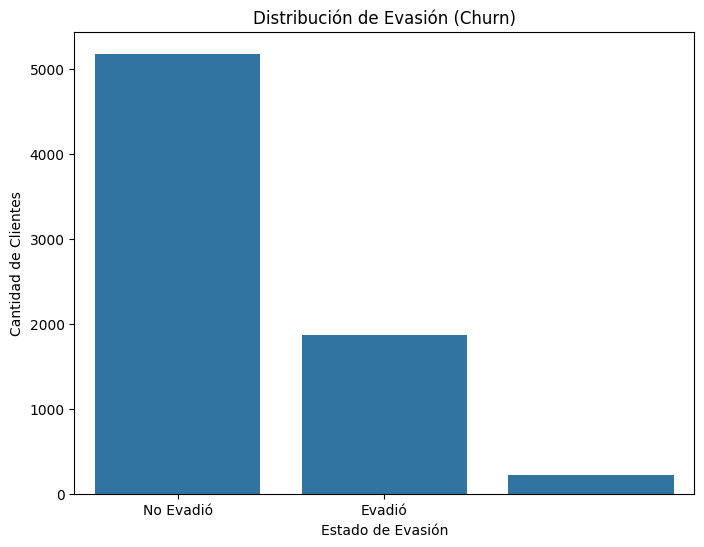

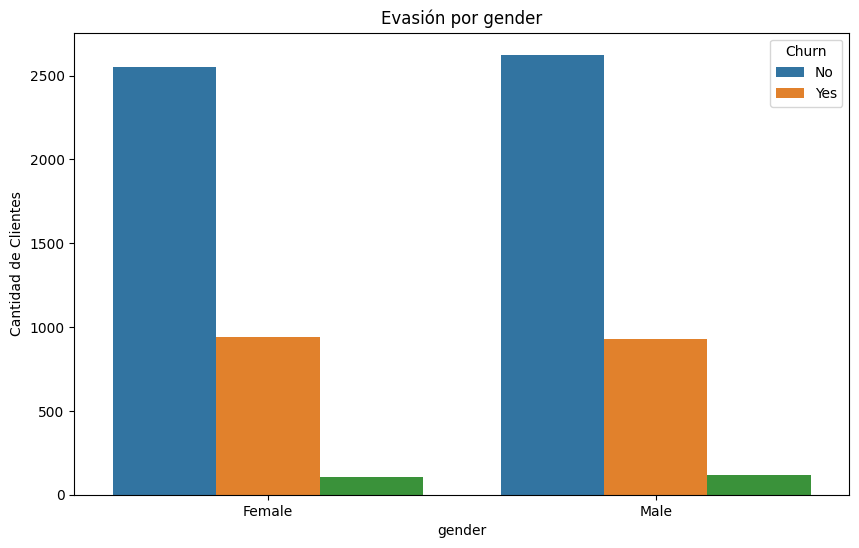

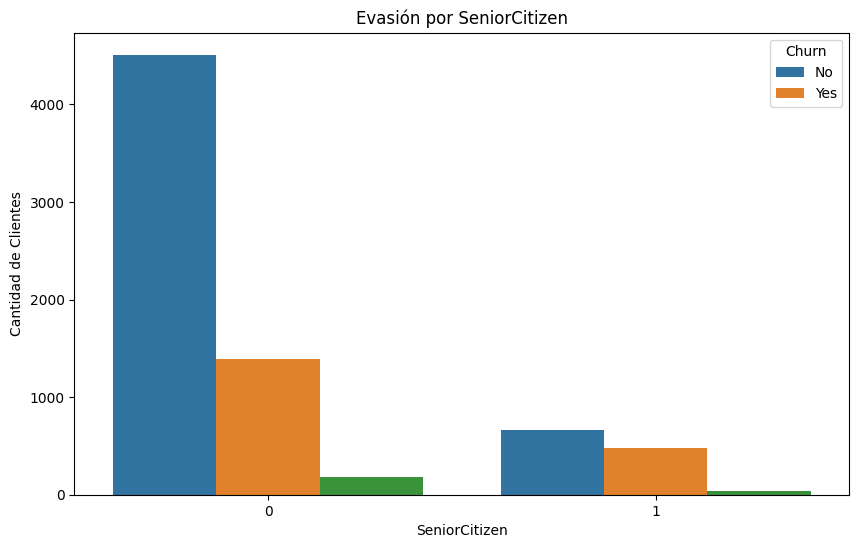

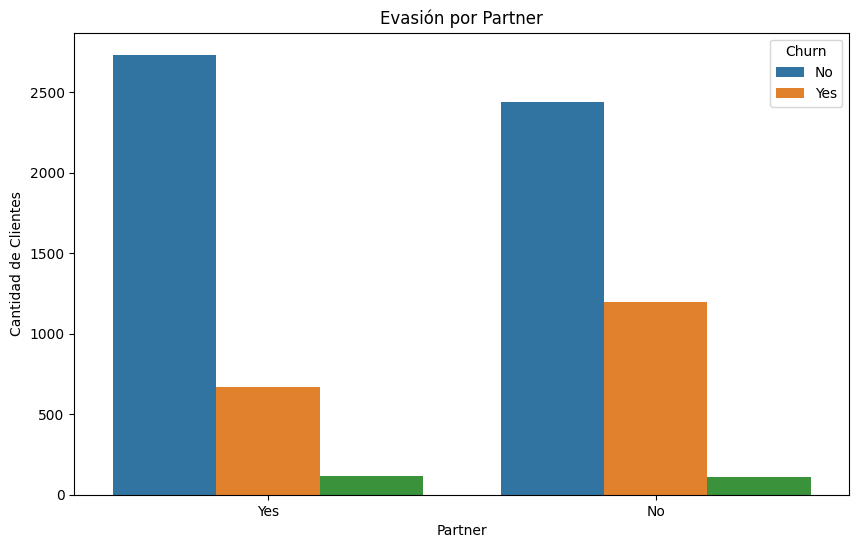

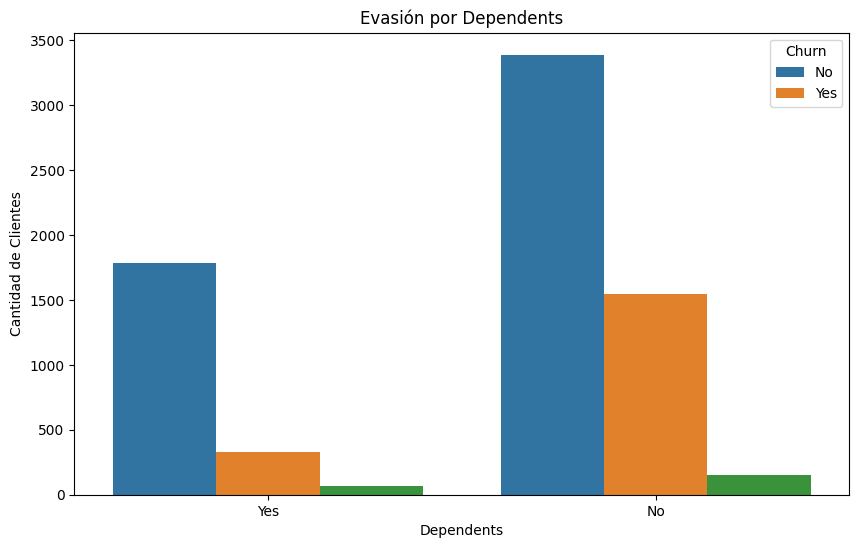

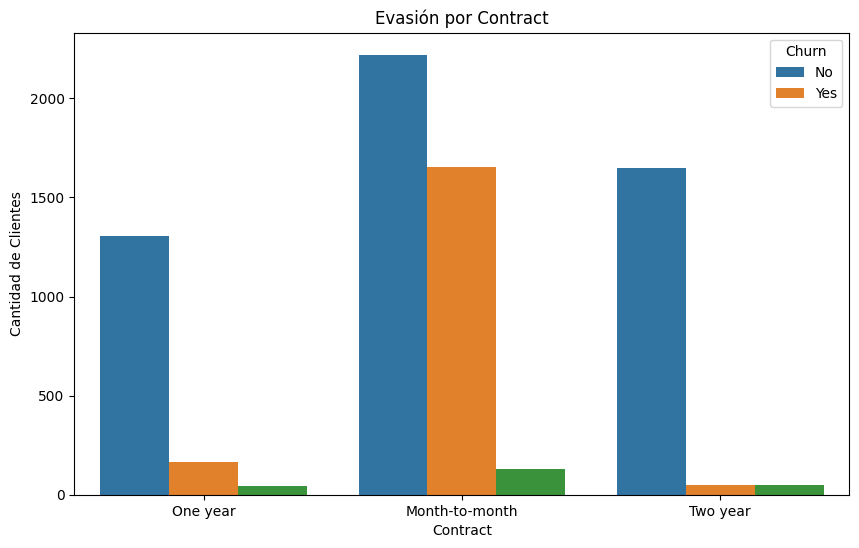

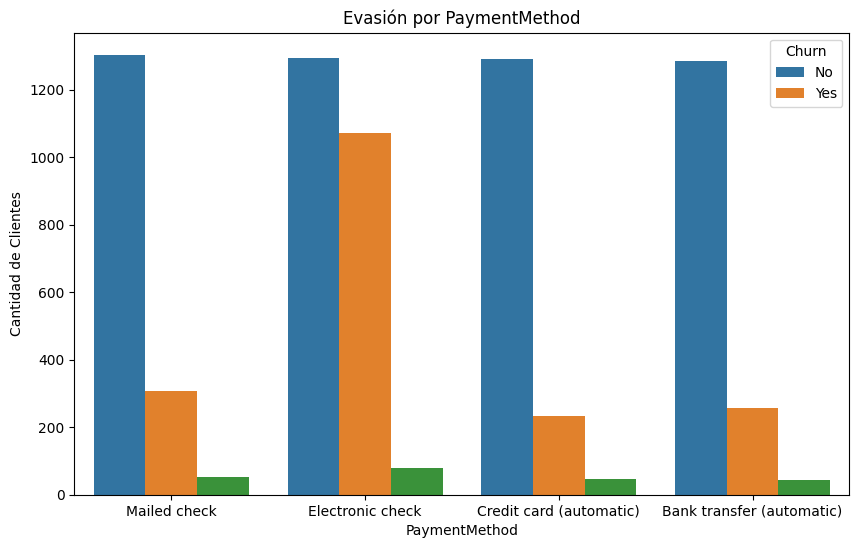

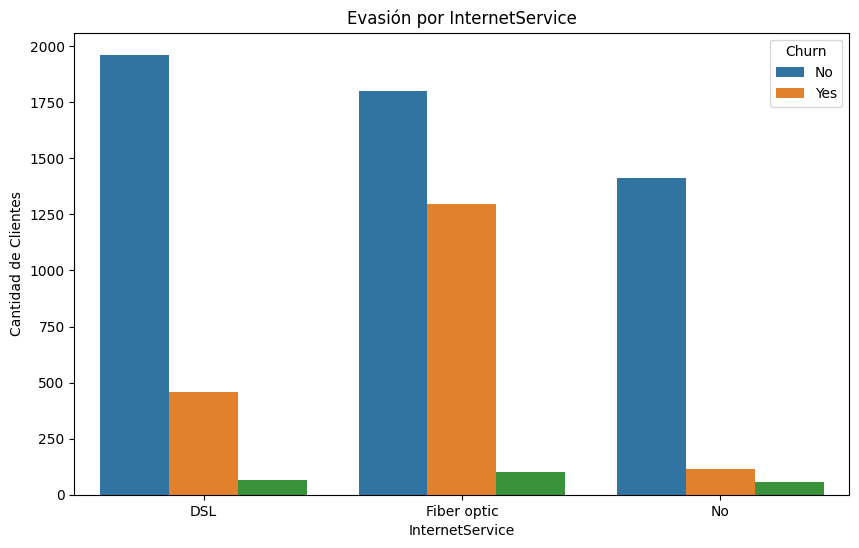

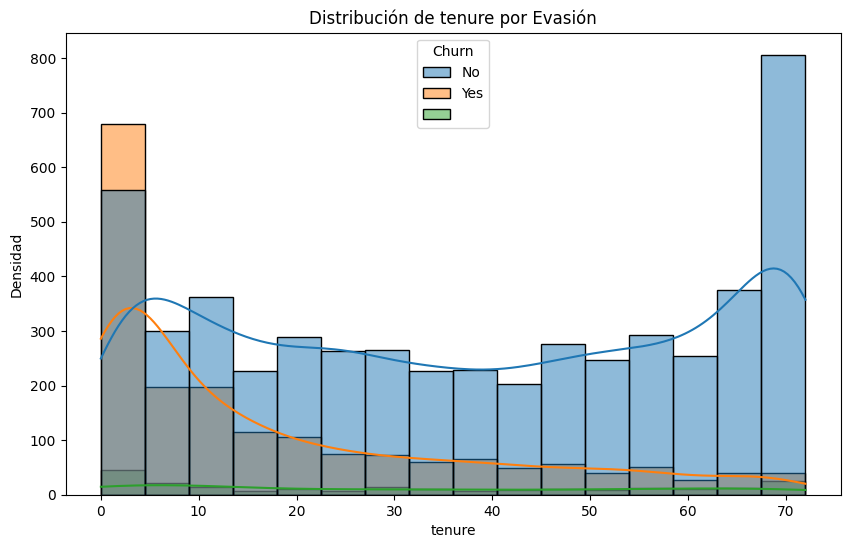

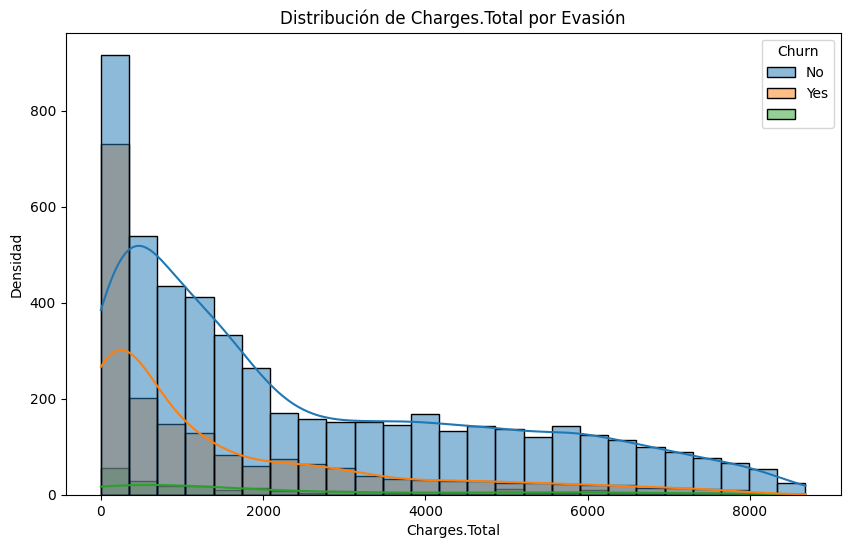

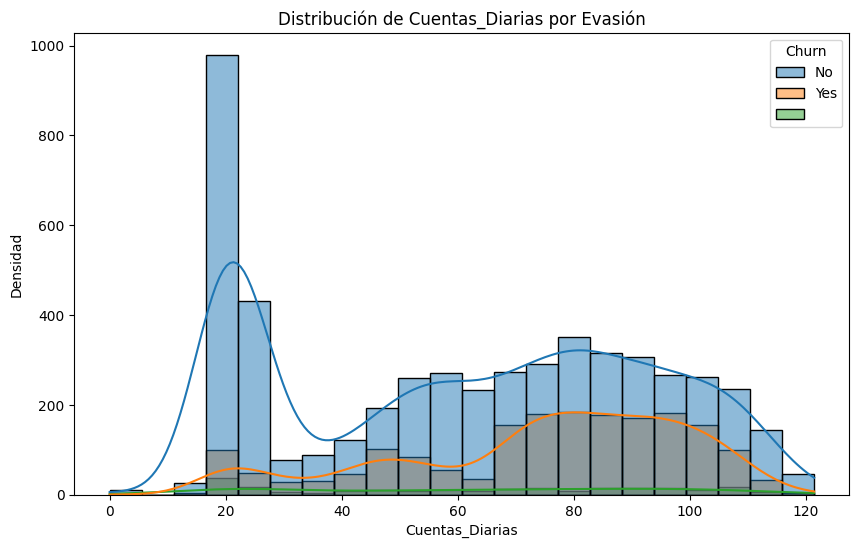


--- 4. INFORME FINAL ---

 Informe Final del Análisis de Evasión de Clientes (Churn)

 Introducción
El objetivo de este análisis es comprender los factores que contribuyen a la evasión de clientes en Telecom X. La empresa enfrenta una alta tasa de cancelaciones y, mediante el análisis exploratorio de datos, buscamos identificar patrones y obtener insights que ayuden a reducir el 'churn'.

 Limpieza y Tratamiento de Datos
- Extracción: Se cargaron los datos directamente desde una API pública en formato JSON y se convirtieron a un DataFrame de Pandas.
- Normalización: Se normalizaron las columnas anidadas ('customer', 'phone', 'internet', 'account') para crear una estructura de DataFrame plana y más fácil de analizar.
- Inconsistencias: Se identificaron y trataron los valores ausentes y los formatos incorrectos en la columna 'Charges.Total', convirtiéndolos a tipo numérico y rellenando los valores faltantes con cero.
- Nuevas Variables: Se creó la columna 'Cuentas_Diarias' a partir de '

In [11]:
# Importamos las bibliotecas necesarias para el análisis de datos.
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. EXTRACCIÓN DE DATOS ---
print("--- 1. EXTRACCIÓN DE DATOS ---")

# Enlace de la API proporcionado en el PDF.
api_url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    # Realizamos una solicitud HTTP GET para obtener los datos de la API.
    response = requests.get(api_url)
    response.raise_for_status()  # Lanza una excepción para errores HTTP.

    # Cargamos los datos JSON directamente en un DataFrame de Pandas.
    df = pd.DataFrame(response.json())
    print("Datos cargados exitosamente en un DataFrame de Pandas.")
    print("DataFrame inicial (datos anidados):")
    print(df.head()) # Muestra las primeras 5 filas para verificar la carga.
except requests.exceptions.RequestException as e:
    print(f"Error al cargar los datos desde la API: {e}")
    df = None # En caso de error, el DataFrame se establece en None.

# Si no se pudo cargar el DataFrame, terminamos la ejecución del script.
if df is None:
    exit()

# --- 2. TRANSFORMACIÓN DE DATOS ---
print("\n--- 2. TRANSFORMACIÓN DE DATOS ---")

# Exploración inicial del dataset con los datos anidados.
print("\nInformación del DataFrame inicial:")
df.info()

# Normalizamos las columnas con datos anidados ('customer', 'phone', 'internet', 'account').
# Esto las convertirá en nuevas columnas de nivel superior.
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Concatenamos los DataFrames normalizados al DataFrame original y eliminamos las columnas anidadas.
df_clean = pd.concat([df.drop(columns=['customer', 'phone', 'internet', 'account']),
                      df_customer, df_phone, df_internet, df_account], axis=1)

df = df_clean.copy()

print("\nDataFrame después de la normalización de datos:")
print(df.head())
print("\nInformación del DataFrame normalizado:")
df.info()

# Comprobación de incoherencias en los datos:
# El PDF menciona inconsistencias, y un problema común es que los datos numéricos
# estén como strings o contengan espacios.
print("\nVerificando inconsistencias en 'Charges.Total'...")
# Limpiamos los espacios en blanco y convertimos la columna a tipo numérico.
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'].str.strip(), errors='coerce')
# 'errors=coerce' convierte los valores no numéricos en NaN.

# Manejo de valores ausentes (NaN) en la columna 'Charges.Total'.
# El PDF indica "Manejo de inconsistencias". Una forma de manejar los NaN es llenarlos
# con la media, mediana o eliminarlos. En este caso, llenaremos los valores
# ausentes con 0, asumiendo que un cliente sin gasto no tiene un total registrado.
# También es importante considerar que estos pueden ser clientes nuevos.
df['Charges.Total'].fillna(0, inplace=True)
print("Valores ausentes en 'Charges.Total' llenados con 0.")

# Convertimos la columna 'tenure' a tipo numérico.
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['tenure'].fillna(0, inplace=True)

# Creamos la columna 'Cuentas_Diarias' (del PDF) dividiendo 'Charges.Total' por 'tenure'.
# Para evitar división por cero, usamos una simple condición.
# En este caso, si el tiempo de contrato es 0, la cuenta diaria es 0.
df['Cuentas_Diarias'] = df.apply(lambda row: row['Charges.Total'] / row['tenure'] if row['tenure'] > 0 else 0, axis=1)
print("\nColumna 'Cuentas_Diarias' creada exitosamente.")
print(df[['Charges.Total', 'tenure', 'Cuentas_Diarias']].head())


# --- 3. ANÁLISIS DESCRIPTIVO Y EDA (Análisis Exploratorio de Datos) ---
print("\n--- 3. ANÁLISIS DESCRIPTIVO Y EDA ---")

# Resumen estadístico de las variables numéricas.
print("\nResumen Estadístico del DataFrame:")
print(df.describe())

# Distribución de la evasión ('churn').
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Evasión (Churn)')
plt.xlabel('Estado de Evasión')
plt.ylabel('Cantidad de Clientes')
plt.xticks(ticks=[0, 1], labels=['No Evadió', 'Evadió'])
plt.show()

# Conteo de evasión por variables categóricas.
# Se seleccionan algunas variables categóricas relevantes para el análisis.
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod', 'InternetService']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Evasión por {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad de Clientes')
    plt.show()

# Conteo de evasión por variables numéricas.
# Se utilizan histogramas o gráficos de densidad para visualizar la distribución.
numerical_cols = ['tenure', 'Charges.Total', 'Cuentas_Diarias']
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue='Churn', kde=True)
    plt.title(f'Distribución de {col} por Evasión')
    plt.xlabel(col)
    plt.ylabel('Densidad')
    plt.show()

# --- 4. INFORME FINAL (en el mismo notebook) ---
print("\n--- 4. INFORME FINAL ---")
print("\n Informe Final del Análisis de Evasión de Clientes (Churn)")
print("\n Introducción")
print("El objetivo de este análisis es comprender los factores que contribuyen a la evasión de clientes en Telecom X. La empresa enfrenta una alta tasa de cancelaciones y, mediante el análisis exploratorio de datos, buscamos identificar patrones y obtener insights que ayuden a reducir el 'churn'.")

print("\n Limpieza y Tratamiento de Datos")
print("- Extracción: Se cargaron los datos directamente desde una API pública en formato JSON y se convirtieron a un DataFrame de Pandas.")
print("- Normalización: Se normalizaron las columnas anidadas ('customer', 'phone', 'internet', 'account') para crear una estructura de DataFrame plana y más fácil de analizar.")
print("- Inconsistencias: Se identificaron y trataron los valores ausentes y los formatos incorrectos en la columna 'Charges.Total', convirtiéndolos a tipo numérico y rellenando los valores faltantes con cero.")
print("- Nuevas Variables: Se creó la columna 'Cuentas_Diarias' a partir de 'Charges.Total' y 'tenure' para obtener una visión más detallada del gasto diario.")

print("\n Análisis Exploratorio de Datos (EDA)")
print("- Distribución de Evasión: El análisis inicial mostro la proporción de clientes que se han dado de baja, proporcionando una base para el estudio.")
print("- Variables Categóricas: Los gráficos por variables como 'Contract' y 'PaymentMethod' revelaron que los clientes con contratos mensuales y ciertos métodos de pago tienen una mayor tendencia a la evasión. Esto sugiere que la flexibilidad del contrato y la facilidad de pago son factores cruciales.")
print("- Variables Numéricas: Los histogramas de 'tenure' y 'Charges.Total' indicaron que los clientes que evaden tienden a tener un tiempo de contrato más corto y un total gastado menor. Esto refuerza la idea de que los clientes de corto plazo son más propensos a cancelar el servicio.")

print("\n Conclusiones e Insights")
print("Los principales hallazgos sugieren que la evasión está fuertemente relacionada con el tipo de contrato, la antigüedad del cliente y los métodos de pago. Los clientes con contratos de mes a mes, un menor tiempo de permanencia y un gasto total más bajo son los perfiles con mayor riesgo de evasión. Esto nos da una idea clara de a qué segmentos de clientes se debe prestar mayor atención.")

print("\n Recomendaciones")
print("- Programas de Lealtad: Ofrecer incentivos y programas de lealtad a los clientes que han estado con la empresa por un corto período de tiempo para fomentar su permanencia.")
print("- Planes de Contrato: Promover planes de contrato más largoss, como contratos anuales, a través de beneficios exclusivos, como descuentos o servicios adicionales, para reducir la tasa de 'churn' mensual.")
print("- Análisis de Métodos de Pago: Investigar si hay problemas o fricciones con ciertos métodos de pago que están asociados con la evasión y buscar formas de simplificar el proceso.")
print("Estos insights pueden ser utilizados por el equipo de marketing y ventas para desarrollar estrategias de retención más efectivas y personalizadas.")
